# Digit Classification with KNN and Naive Bayes

In this project, I'll implement an image recognition system for classifying digits using the MNIST digit data available throught the scikit-learn package

Background Reading:  
 - Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
 - Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from pprint import pprint
from scipy.signal import convolve2d

print sklearn.__version__
print np.__version__

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

0.19.2
1.15.3


C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Load the data
Load and split the data into training, development, and test. Also create a small subset of the training data called mini_train_data and mini_train_labels

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk.
mnist = fetch_mldata('MNIST (original)', data_home='./')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1]
X = X / 255.0

# Shuffle the input
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


Create a 10x10 grid to visualize 10 examples of each digit

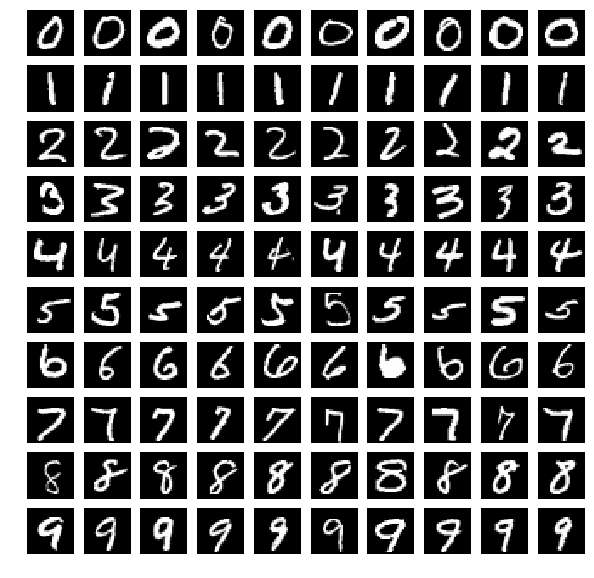

In [5]:
def visualizer(num_examples=10):
    
    # Get the indices of 10 randomly selected examples of each digit
    inds = {
        i: np.random.choice(np.where(Y == i)[0], size=num_examples) 
        for i in range(10)
    }
    
    # Plot all examples in a 10x10 grid
    k = 0
    plt.figure(figsize=(10,10))
    for i in range(len(inds)):
        for j in range(len(inds[0])):
            k += 1
            img = np.reshape(X[inds[i][j]], [28,28], order='C')
            plt.subplot(10, 10, k)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
visualizer(10)

## Compare prediction accuracy of each Digit
Using a kNN model on the mini training set with k = [1,3,5,7,9], determine which digit is the most difficult to predict

In [6]:
def accuracy_table(k_values, train_data, train_labels, test_data, test_labels):
    
    # build a kNN model for each k in k_values
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors = k)
        model.fit(train_data, train_labels)
        pred = model.predict(test_data)
        score = model.score(test_data, test_labels)
        
        # calculate accuracy score of each digit
        acc = {
            int(i): accuracy_score(
                pred[test_labels == i], test_labels[test_labels == i]
            ) 
            for i in np.unique(test_labels)
        }
        
        # print results
        print '\nK =', k,
        print '\nMean Accuracy:', score
        print '\nAccuracy per digit:\n'
        pprint(acc)
        print '\nClassification Report:\n'
        print classification_report(
            test_labels, pred, labels = list(range(10))
        )

k_values = [1, 3, 5, 7, 9]
accuracy_table(k_values, mini_train_data, mini_train_labels, dev_data, dev_labels)

### STUDENT END ###


K = 1 
Mean Accuracy: 0.888

Accuracy per digit:

{0: 0.9797979797979798,
 1: 1.0,
 2: 0.7941176470588235,
 3: 0.872093023255814,
 4: 0.8173076923076923,
 5: 0.8351648351648352,
 6: 0.9591836734693877,
 7: 0.9203539823008849,
 8: 0.875,
 9: 0.8207547169811321}

Classification Report:

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000


K = 3 
Mean Accuracy: 0.878

Accuracy per digit:

{0: 1.0,
 1: 1.0,
 2: 0

The answer to which digit is hardest to predict varies based on the value of k. When k = 1, the digit `9` has the worst F1 score, but the digit `2` has the worst accuracy. When k = 3, the digit `5` has the worst accuracy, but `3` has by far the worst F1 score, etc. Overall, the digit `9` consistently ranks lowest or close to it in F1-score which balances precision and recall, and is typically in the bottom half of the accuracy scores, so overall I would argue `9` is the hardest digit to predict

## Using different training sizes
Determine the accuracy of the dev set using training sizes of [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]

In [ ]:
def compare_tsize(
    train_sizes, accuracy, train_data, train_labels, test_data, test_labels
):
    for n in train_sizes:
        
        # grab a random sample of size n from the training data
        idx = np.random.choice(np.arange(len(train_data)), size=n, replace=False)
        sample_data = train_data[idx]
        sample_labels = train_labels[idx]
        
        # build the kNN model with k = 1
        model = KNeighborsClassifier(n_neighbors = 1)
        model.fit(sample_data, sample_labels)
        
        # calculate the time for prediction
        start = time.time()
        pred = model.predict(test_data)
        pred_time = time.time() - start
        
        # acc = sum(pred == dev_labels) / len(pred)
        acc = accuracy_score(pred, test_labels)
#         accuracy[int(n)] = (acc, round(pred_time, 4))
        accuracy[int(n)] = {'Accuracy':acc, 'Runtime':round(pred_time, 4)}
        
    return accuracy

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracy = {}

start = time.time()
accuracy = compare_tsize(
    train_sizes, accuracy, train_data, train_labels, dev_data, dev_labels
)
pprint(accuracy)
print "\nTotal runtime:", round(time.time() - start,4), "seconds"

## Predict Accuracy from Training Size
Look at the limitations of predicting accuracy from training size using a linear regression model. Attempt to predict the accuracy for a training size of 60000

In [3]:
# using 'accuracy' dict from above cell for linear regression model
x = [[k] for k in accuracy.keys()]
y = [v[0] for v in accuracy.values()]
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(x,y,'.')
plt.title('Original Data')
plt.subplot(122)
plt.plot(np.log(x),y,'.')
plt.title('Log Transformation of Original Data')

# The first plot indicates that a log transformation is appropriate and the
# second plot confirms that the shape is much more linear in log form

def lin_pred(x,y, prediction_value):
    lm = LinearRegression()
    lm.fit(x,y)
    pred = lm.predict(prediction_value)
    return pred[0]

# accuracy vs training size linear
pred_accuracy1 = lin_pred(x,y,60000)

# accuracy vs training size logarithmic
pred_accuracy2 = lin_pred(np.log(x), y, np.log(60000))

print "Predicted accuracy with original data:", pred_accuracy1
print "Predicted accuracy with log transformation:", pred_accuracy2

NameError: name 'accuracy' is not defined

The accuracy vs. training size data collected in P3 only goes up to a training size of 25000. So using this  data to model a training size of 60000 is a huge extrapolation and this shows by giving a predicted accuracy of ~1.25. This is impossible since we cannot be better than getting 100% of the predicted answers correct. Plotting the data shows that the relationship between accuracy and time is quite nonlinear, and the shape suggests that a log transformation might be appropriate. Looking at the data after taking the log of the training size shows a more linear relationship and modeling a training a size of 60000 now reports a predicted accuracy of 1.03. Still impossible, but much closer to reality. This just shows that we would like to collect more data to improve the regression model, in order to improve this accuracy.

## Confusion Matrix
Identify the most confused pairs of digits using a confusion matrix

[[ 99   0   0   0   0   0   0   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  1   0  98   2   0   0   0   1   0   0]
 [  0   0   0  83   0   1   0   0   1   1]
 [  0   0   0   0 102   0   0   0   0   2]
 [  1   0   0   0   0  88   0   0   1   1]
 [  1   0   0   0   1   0  96   0   0   0]
 [  0   0   1   0   0   0   0 111   0   1]
 [  1   0   1   2   0   2   1   0  89   0]
 [  0   0   0   0   0   0   0   0   0 106]]

the most confused pair(s) was/were (first digit is true value, second digit is predicted value):
[(2, 3), (4, 9), (8, 3), (8, 5)]


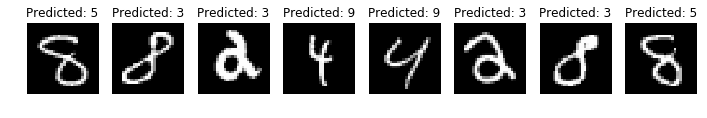

In [4]:
def build_cmatrix(dev_data, dev_labels, training_size=1000):
    
    # grab a random sample of size training_size from the training data
    inds = np.random.choice(np.arange(len(train_data)), size=training_size, replace=False)
    sample_data = train_data[inds]
    sample_labels = train_labels[inds]

    # build the kNN model with k = 1 and predict using the dev data
    model = KNeighborsClassifier(n_neighbors = 1)
    model.fit(sample_data, sample_labels)
    pred = model.predict(dev_data)
    
    # build confusion matrix
    cm = confusion_matrix(dev_labels, pred)
    print cm
    
    return pred, cm
    
pred, cm = build_cmatrix(dev_data, dev_labels, len(train_data))

# Find the most confused pair of digits by grabbing the row, col index in the 
# confusion matrix
val = np.max(cm[cm != np.diag(cm)])
idx = [i for i in np.ndindex(cm.shape) if cm[i] == val]

print '\nthe most confused pair(s) was/were (first digit is true value,',
print 'second digit is predicted value):'
print idx

temp = {
    i: (pred[i], dev_labels[i]) for i in range(pred.shape[0]) 
    if pred[i] != dev_labels[i]
}
digits = [k for k,v in temp.items() if cm[int(v[1]), int(v[0])] == val]

# plot the examples
k = 0
plt.figure(figsize=(12,8))
for i in range(len(digits)):
    k += 1
    img = dev_data[digits[i]]
    plt.subplot(1, len(digits), k)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.title('Predicted: {}'.format(int(pred[digits[i]])))
    plt.axis('off')

## Adding Image Processing
Build a simple Gaussian blur approximation and attempt to improve the prediction accuracy


K = 1 
Mean Accuracy: 0.104

Accuracy per digit:

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 1.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

Classification Report:

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        99
          1       0.00      0.00      0.00       105
          2       0.00      0.00      0.00       102
          3       0.00      0.00      0.00        86
          4       0.10      1.00      0.19       104
          5       0.00      0.00      0.00        91
          6       0.00      0.00      0.00        98
          7       0.00      0.00      0.00       113
          8       0.00      0.00      0.00        96
          9       0.00      0.00      0.00       106

avg / total       0.01      0.10      0.02      1000

Test 1 runtime: 403.617000103


C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



K = 1 
Mean Accuracy: 0.105

Accuracy per digit:

{0: 0.0,
 1: 1.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

Classification Report:

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        99
          1       0.10      1.00      0.19       105
          2       0.00      0.00      0.00       102
          3       0.00      0.00      0.00        86
          4       0.00      0.00      0.00       104
          5       0.00      0.00      0.00        91
          6       0.00      0.00      0.00        98
          7       0.00      0.00      0.00       113
          8       0.00      0.00      0.00        96
          9       0.00      0.00      0.00       106

avg / total       0.01      0.10      0.02      1000

Test 2 runtime: 321.309000015

K = 1 
Mean Accuracy: 0.104

Accuracy per digit:

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 1.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0}

Classification Report:


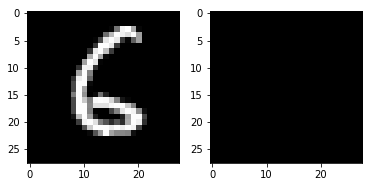

In [7]:
### STUDENT START ###

# define a simplified Gaussian blur function. 
# approximate guassian blur kernel defined here: https://en.wikipedia.org/wiki/Kernel_(image_processing)
def G_blur(img):
    kernel = np.array([[1,2,1], [2,4,2], [1,2,1]]) * (1/16)
    img2 = convolve2d(img.reshape(28,28).copy(), kernel, boundary='wrap', mode='same')
    return img2.reshape(784)

# create function see effect of G_blur application
def before_after(img, img2):
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(img2, cmap='gray')

# visualize simple gaussian blur
img = train_data[np.random.randint(0, train_data.shape[0], 1)[0]]
img2 = G_blur(img)
before_after(img.reshape(28,28), img2.reshape(28,28))

def apply_blur():
    ## TEST 1: 
    # preprocess training data, but not the dev data
    start = time.time()
    trainer = np.array(map(G_blur, train_data.copy()))

    # recycle P2 function to display results
    k_values = [1]
    accuracy_table(k_values, trainer, train_labels, dev_data, dev_labels)
    print "Test 1 runtime:", time.time() - start

    ## TEST 2: 
    # preprocess dev data, but not the training data
    start = time.time()
    dev = np.array(map(G_blur, dev_data.copy()))

    # recycle P2 function to display results
    k_values = [1]
    accuracy_table(k_values, train_data, train_labels, dev, dev_labels)
    print "Test 2 runtime:", time.time() - start

    ## TEST 3: 
    # preprocess both dev data and training data
    start = time.time()

    # recycle P2 function to display results
    k_values = [1]
    accuracy_table(k_values, trainer, train_labels, dev, dev_labels)
    print "Test 3 runtime:", time.time() - start

apply_blur()
### STUDENT END ###

The best result by a very slight edge is to preprocess both the training data and the dev data. The overall accuracy is highest here, but only by a very slight margin over preprocessing only the training data. However, preprocessing the dev data only isn't that far off from either of these results, so depending on the size of your data set and the desired accuracy of your model, you may want to consider preprocessing only the dev data to save computational time.

## Exploring Naive Bayes
Map pixel values to [0,1] and train a Bernoulli Naive Bayes model, then map pixel values to [0,1,2] and train a Multinomial Naive Bayes model and compare the predictions

In [8]:
## Compare a Bernoulli Naive Bayes model using binarized training data to a 
## Multinomial Naive Bayes model using three level data

# find a threshold for binarization. I used the mean + 2 * st. deviation of the 
# pixels
m = np.mean(np.mean(X,1))
sd = np.mean(np.std(X,1))
thresh = m + 2*sd

# apply the Bernoulli Naive Bayes model
BNB = BernoulliNB(binarize=thresh, alpha=0.0)
BNB.fit(train_data, train_labels)
print 'Bernoulli model accuracy:', BNB.score(dev_data, dev_labels)

# define a function for creating multi-level pixel values of 0,1,2
def levels(img, thresh):
    for i, pixel in enumerate(img):
        if pixel < thresh[0]:
            pixel = 0
        elif thresh[0] <= pixel < thresh[1]:
            pixel = 1
        else:
            pixel = 2
        img[i] = pixel
        
    return img

# define thresholds for the multiple levels
thresh = [m + sd, m + 2*sd]

# apply the levels function to the training data and the dev data
train_data_levels = np.array(map(lambda x: levels(x, thresh), train_data.copy()))
dev_data_levels = np.array(map(lambda x: levels(x, thresh), dev_data.copy()))

# train the multinomial NB model
MNB = MultinomialNB(alpha=0.0)
MNB.fit(train_data_levels, train_labels)
print 'Multinomial model accuracy:', MNB.score(dev_data_levels, dev_labels)

C:\Users\alexd\Anaconda3\envs\ipy27\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Bernoulli model accuracy: 0.843
Multinomial model accuracy: 0.829


The Multinomial NB model hardly improved the results for this selection of training data. I believe the efficiency trade off of using the Bernoulli model outweighs the minor increase in performance, especially since a different random selection of training data may or may not yield the same improvement

## GridSearch
Use GridSearch to determine the optimal value of the Laplace smoothing parameter, alpha

In [9]:
def optimize_alpha(alphas, train_data, train_labels, dev_data, dev_labels):
    
    # determine a threshold for binarization
    mn = np.mean(np.mean(train_data,1))
    sd = np.mean(np.std(train_data,1))
    thresh = [mn + 2*sd]
    
    # set parameters and perform grid serach over the varying alpha values
    params = {'binarize': thresh, 'alpha': alphas}
    gs = GridSearchCV(BernoulliNB(), params)
    gs.fit(train_data, train_labels)
    
    # display results
    print '\nGrid Scores:\n' 
    pprint(gs.grid_scores_)
    print '\nBest Score:\n'
    pprint(gs.best_score_)
    print '\nBest Parameters:\n'
    pprint(gs.best_params_)
    
    return gs

alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
gs = optimize_alpha(alphas, train_data, train_labels, dev_data, dev_labels)


Grid Scores:

[mean: 0.83147, std: 0.00239, params: {'binarize': 0.734274616231464, 'alpha': 0.0},
 mean: 0.83090, std: 0.00263, params: {'binarize': 0.734274616231464, 'alpha': 0.0001},
 mean: 0.83063, std: 0.00276, params: {'binarize': 0.734274616231464, 'alpha': 0.001},
 mean: 0.83018, std: 0.00281, params: {'binarize': 0.734274616231464, 'alpha': 0.01},
 mean: 0.82968, std: 0.00298, params: {'binarize': 0.734274616231464, 'alpha': 0.1},
 mean: 0.82892, std: 0.00314, params: {'binarize': 0.734274616231464, 'alpha': 0.5},
 mean: 0.82850, std: 0.00302, params: {'binarize': 0.734274616231464, 'alpha': 1.0},
 mean: 0.82788, std: 0.00283, params: {'binarize': 0.734274616231464, 'alpha': 2.0},
 mean: 0.82510, std: 0.00236, params: {'binarize': 0.734274616231464, 'alpha': 10.0}]

Best Score:

0.8314666666666667

Best Parameters:

{'alpha': 0.0, 'binarize': 0.734274616231464}


At alpha=0, the accuracy is 83.15% which is the highest level of accuracy in the grid search we performed. This means that no smoothing at all was the most accurate way to apply a Bernoulli NB model. I think this makes sense because the to use a Bernoulli NB model we have binarized the data so that it is either 1 or 0 which makes the features that define the digit (the white pixels) as distinct as possible from the features that do not describe the background (0's). Applying a Laplace smoothing to this data would, in effect, undo some of feature distinction and therefore open more room for erroneous predictions

(9) Try training a model using GaussianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

## Gaussian Naive Bayes
Observe that the data does not have a gaussian distribution. Apply some gaussian noise and fit a GaussianNB model

Accuracy of Gaussian NB model on untransformed data: 0.571
Accuracy of Gaussian NB model with Gaussian noise added: 0.833


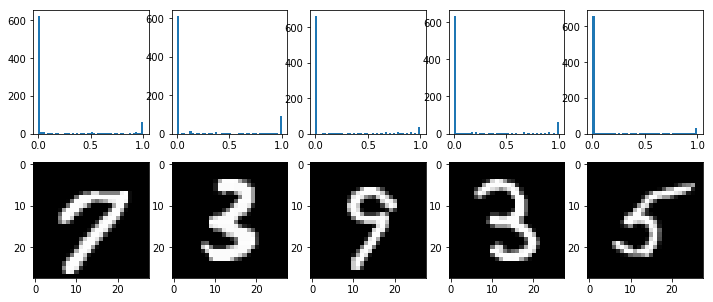

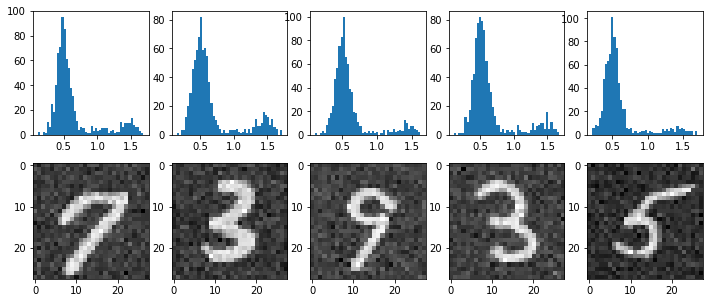

In [10]:
# Examine the distribution of 5 random samples of the training data
plt.figure(figsize=(12,5))
idx = np.random.choice(np.arange(len(train_data)), size=5)
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.hist(train_data[idx[i]], bins=50)
    plt.subplot(2,5,i+6)
    plt.imshow(train_data[idx[i]].reshape(28,28), cmap='gray')
    
# transform the data by adding Gaussian noise to it and examine the histograms
t2 =  np.array(
        map(lambda x: np.random.normal(loc=0.5, scale=0.1, size=784) + 
            x, train_data.copy()
           )
    )
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.hist(t2[idx[i]], bins=50)
    plt.subplot(2,5,i+6)
    plt.imshow(t2[idx[i]].reshape(28,28), cmap='gray')

# Build a function that adds Gaussian noise to the image
def compare_GNB(train_data, train_labels, dev_data, dev_labels):
    
    # Create a Gaussian NB model
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    print 'Accuracy of Gaussian NB model on untransformed data:', 
    print gnb.score(dev_data, dev_labels)
    
    # transform the data by adding Gaussian noise to each image
    t2 =  np.array(
        map(lambda x: np.random.normal(loc=0.5, scale=0.1, size=784) + 
            x, train_data.copy()
           )
    )
    d2 =  np.array(
        map(lambda x: np.random.normal(loc=0.5, scale=0.1, size=784) + 
            x, dev_data.copy()
           )
    )
    gnb.fit(t2, train_labels)
    print 'Accuracy of Gaussian NB model with Gaussian noise added:',
    print gnb.score(d2, dev_labels)
    
    return gnb

gnb = compare_GNB(train_data, train_labels, dev_data, dev_labels)

The Gaussian NB model assumes that the data you are training it with has a Gaussian distribution. Our training data does not have a Gaussian distribution which can be seen by looking at the histograms of 5 random samples of the training data (top row). By adding in some random noise from a Gaussian distribution, we can make each image look a little more Gaussian to the model. The bottom row of histograms shows the same 5 random samples, transformed by adding Gaussian noise to the image, thus making the distribution of each image slightly more Gaussian and allowing the model to process the data better

## Generative Models
Use the generative power of a Bernoulli Naive Bayes model to generate 20 examples of each of the 10 digits

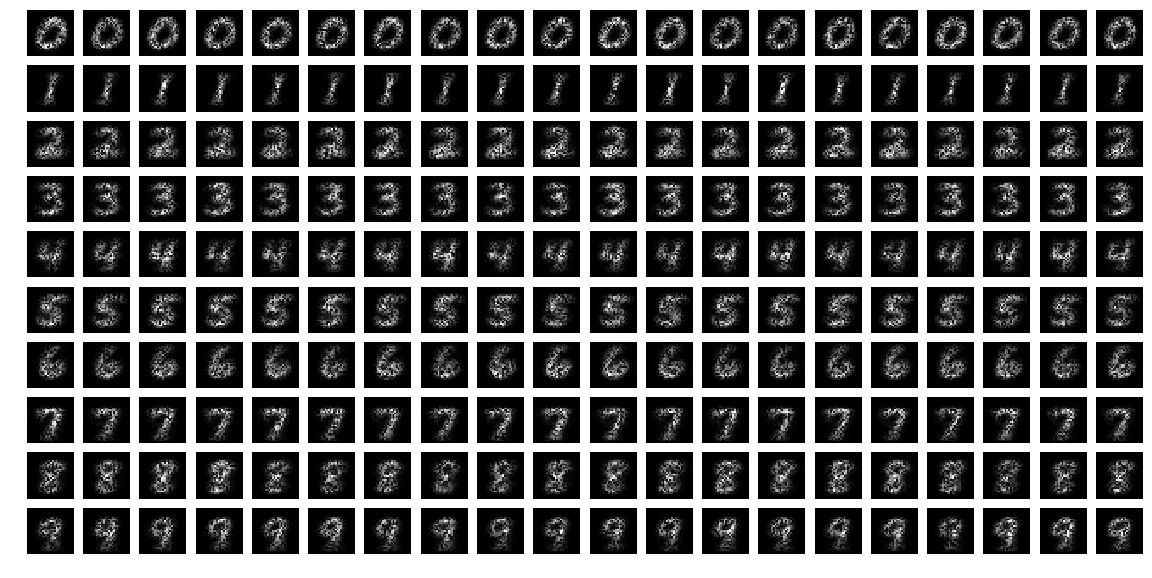

In [11]:
def generate_examples(num_examples, train_data, train_labels):
    
    # determine a threshold for binarizing. I used the mean + 2*st. deviation
    m = np.mean(np.mean(train_data,1))
    sd = np.mean(np.std(train_data,1))
    thresh = m + 2*sd
    
    # Train a Bernoulli NB model with binarization using the training data
    BNB = BernoulliNB(binarize=thresh)
    BNB.fit(train_data, train_labels)
    
    # The feature_log_prob_ to generate 'num_examples' samples of each digit by
    # mapping random noise to the feature probabilities
    fp = np.exp(BNB.feature_log_prob_)
    plt.figure(figsize=(20,10))
    k = 0
    for j in range(10):
        for i in range(num_examples):       
            k += 1
            noise = np.random.rand(784)
            example = (noise * fp[j])
            example = example / np.max(example) # normalize
            plt.subplot(10, 20, k)
            plt.imshow(example.reshape(28,28), cmap='gray')
            plt.axis('off')

generate_examples(20, train_data, train_labels)

The generated digits have much less variability in the shape of the digit, than the training data do. The generated digits also appear broken due to the random noise being multiplied by the pixel probabilities which allows for situations where a pixel with high likelihood to be white, is multiplied by a very small value of noise, thus causing it to come out as black.

## Classifier Calibration
Determine whether or not the BernoulliNB model is strongly or weakly calibrated

In [12]:
# define a function to select the correct bucket for the posterior
def pick_bucket(prob, buckets):
    m = np.max(prob)
    idx = np.argmin(np.abs(buckets - m))
    if buckets[idx] - m > 0:
        idx -= 1
    return idx

def meas_calibration(buckets, correct, total):
    
    # define a threshold for binarization
    m = np.mean(np.mean(train_data,1))
    sd = np.mean(np.std(train_data,1))
    thresh = m + 2*sd
    
    # Train a Bernoulli NB model on the training data and get the posteriors 
    # and the predictions
    bnb = BernoulliNB(binarize=thresh, alpha=0.0)
    bnb.fit(train_data, train_labels)
    probs = bnb.predict_proba(dev_data)
    preds = bnb.predict(dev_data)
    
    # Update the counters
    for pred, prob, label in zip(preds, probs, dev_labels):
        b = pick_bucket(prob, buckets)
        if pred == label: correct[b] += 1
        total[b] += 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

meas_calibration(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =  55    accuracy = 0.000
p(pred) <= 0.9000000000000    total = 112    accuracy = 0.000
p(pred) <= 0.9990000000000    total =  93    accuracy = 0.000
p(pred) <= 0.9999900000000    total =  96    accuracy = 0.000
p(pred) <= 0.9999999000000    total =  86    accuracy = 0.000
p(pred) <= 0.9999999990000    total =  90    accuracy = 0.000
p(pred) <= 0.9999999999900    total =  55    accuracy = 0.000
p(pred) <= 0.9999999999999    total =  25    accuracy = 0.000
p(pred) <= 1.0000000000000    total = 388    accuracy = 0.000


The classifier is weakly calibrated. There is a positive correlation between accuracy and posterior probability, but for samples where the posterior is ~90%, the measured accuracy is ~55%. So this is not in the strongly calibrated realm yet.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

## Performance Improvement

In [13]:
'''
Testing two new features on two versions of Naive Bayes models. The first
I will add and test will be the number of enclosed regions in the digit. The 
second feature I will add will be whether or not the digit is even or odd. I 
will test adding these features to both a Multinomial Naive Bayes and a Gaussian
NB model. I chose those two models over a Bernoulli model, since the Bernoulli
model needs binarized data we would lose some information of these new features
after binarizing.
'''

# Define the new features
enc = {0:1, 1:0, 2:0, 3:0, 4:0, 5:0, 6:1, 7:0, 8:2, 9:1}
div_2 = {0:0, 1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:0, 8:1, 9:0}


## Build the multinomial model
# define thresholds for the multiple levels
m = np.mean(np.mean(X,1))
sd = np.mean(np.std(X,1))
thresh = [m + sd, m + 2*sd]

# apply the levels function to the training data and the dev data
train_data_levels = np.array(map(lambda x: levels(x, thresh), train_data.copy()))
dev_data_levels = np.array(map(lambda x: levels(x, thresh), dev_data.copy()))

# add the enclosed region feature by assigning it as the first pixel
t2 = train_data_levels.copy()
for i, img in enumerate(t2):
    img[0] = [v for k,v in enc.items() if train_labels[i] == k][0]
    t2[i] = img    
d2 = dev_data_levels.copy()
for i, img in enumerate(d2):
    img[0] = [v for k,v in enc.items() if dev_labels[i] == k][0]
    d2[i] = img

# add the even/odd flag feature by assigning it to the second pixel
t3 = t2.copy()
for i, img in enumerate(t2):
    img[1] = [v for k,v in div_2.items() if train_labels[i] == k][0]
    t3[i] = img
d3 = d2.copy()
for i, img in enumerate(d2):
    img[1] = [v for k,v in div_2.items() if dev_labels[i] == k][0]
    d3[i] = img

# test the Multinomial NB model with just the enclosed regions feature and just
# with both the enclosed regions and the even/odd flag
MNB = MultinomialNB(alpha=0.0)
MNB.fit(train_data_levels, train_labels)
print 'Original Multinomial NB accuracy:', MNB.score(dev_data_levels, dev_labels)
MNB.fit(t2, train_labels)
print 'Multinomial NB accuracy w/ Enclosed Regions feature:', MNB.score(d2, dev_labels)
MNB.fit(t3, train_labels)
print 'Multinomial NB accuracy w/ Enc. Regions and even/odd flag features:', MNB.score(d3, dev_labels)


## Test the new features in the Gaussian model
# transform the data by adding Gaussian noise to each image
t1 =  np.array(
    map(lambda x: np.random.normal(loc=0.5, scale=0.1, size=784) + 
        x, train_data.copy()
       )
)
d1 =  np.array(
    map(lambda x: np.random.normal(loc=0.5, scale=0.1, size=784) + 
        x, dev_data.copy()
       )
)

# add the enclosed region feature by assigning it as the first pixel
t2 = t1.copy()
for i, img in enumerate(t2):
    img[0] = [v for k,v in enc.items() if train_labels[i] == k][0]
    t2[i] = img
d2 = d1.copy()
for i, img in enumerate(d2):
    img[0] = [v for k,v in enc.items() if dev_labels[i] == k][0]
    d2[i] = img

# add the even/odd flag feature by assigning it to the second pixel
t3 = t2.copy()
for i, img in enumerate(t2):
    img[1] = [v for k,v in div_2.items() if train_labels[i] == k][0]
    t3[i] = img
d3 = d2.copy()
for i, img in enumerate(d2):
    img[1] = [v for k,v in div_2.items() if dev_labels[i] == k][0]
    d3[i] = img

GNB = GaussianNB()
GNB.fit(t1, train_labels)
print 'Original Gaussian NB accuracy:', GNB.score(d1, dev_labels)
GNB.fit(t2, train_labels)
print 'Gaussian NB accuracy w/ Enclosed Regions feature:', GNB.score(d2, dev_labels)
GNB.fit(t3, train_labels)
print 'Gaussian NB accuracy w/ Enc. Regions and even/odd flag features:', GNB.score(d3, dev_labels)

Original Multinomial NB accuracy: 0.829
Multinomial NB accuracy w/ Enclosed Regions feature: 0.878
Multinomial NB accuracy w/ Enc. Regions and even/odd flag features: 0.878
Original Gaussian NB accuracy: 0.841
Gaussian NB accuracy w/ Enclosed Regions feature: 0.954
Gaussian NB accuracy w/ Enc. Regions and even/odd flag features: 0.954


The Multinomial accuracy improved with the addition of the enclosed regions feature, but the addition of the even or odd flag did not help improve the accuracy. The Gaussian NB model improved drastically with the addition of the enclosed regions feature, improving the accuracy to the level of the kNN model. Again the even/odd flag did not help improve the accuracy